# Cluster Analysis using SAS code

#### PROC CLUSTER is the hierarchical clustering method, 
    
#### PROC FASTCLUS is the K-Means clustering and 
    
####  PROC VARCLUS is a special type of clustering where (by default) Principal Component Analysis (PCA) is done to cluster variables.
    

https://subhasis4analytics.blogspot.com/2014/09/cluster-analysis-with-sas.html

### Content
####    Fields in the dataset:  https://www.kaggle.com/datasets/crawford/80-cereals

        Name: Name of cereal
        mfr: Manufacturer of cereal
            A = American Home Food Products;
            G = General Mills
            K = Kelloggs
            N = Nabisco
            P = Post
            Q = Quaker Oats
            R = Ralston Purina
        type:
            cold
            hot
        calories: calories per serving
        protein: grams of protein
        fat: grams of fat
        sodium: milligrams of sodium
        fiber: grams of dietary fiber
        carbo: grams of complex carbohydrates
        sugars: grams of sugars
        potass: milligrams of potassium
        vitamins: vitamins and minerals - 0, 25, or 100, indicating the typical percentage of FDA recommended
        shelf: display shelf (1, 2, or 3, counting from the floor)
        weight: weight in ounces of one serving
        cups: number of cups in one serving
        rating: a rating of the cereals (Possibly from Consumer Reports?)

In [60]:
import sys
try:
    import saspy
except:
    !pip install saspy

In [61]:
# check the version of SASPy
saspy.__version__

'5.4.4'

In [62]:
# Start a SAS session, SAS is running in UTF-8

sas_sess = saspy.SASsession()

Using SAS Config named: oda
SAS Connection established. Subprocess id is 14204



In [63]:
%%SAS sas_sess

FILENAME REFFILE '/home/u61624884/cereal.csv';
   
PROC IMPORT DATAFILE=REFFILE
DBMS=CSV
OUT=WORK.IMPORT;
GETNAMES=YES;
RUN;


/* print first 10 observations */
proc print data=WORK.IMPORT (obs=10);
run;

/* Checking the contents of the datasets */
proc means data=WORK.IMPORT N Nmiss mean median max min;
run;

Obs,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
1,100% Bran,N,C,70,4,1,130,10,5,6,280,25,3,1,0.33,68.402973
2,100% Natural Bran,Q,C,120,3,5,15,2,8,8,135,0,3,1,1,33.983679
3,All-Bran,K,C,70,4,1,260,9,7,5,320,25,3,1,0.33,59.425505
4,All-Bran with Extra Fiber,K,C,50,4,0,140,14,8,0,330,25,3,1,0.5,93.704912
5,Almond Delight,R,C,110,2,2,200,1,14,8,-1,25,3,1,0.75,34.384843
6,Apple Cinnamon Cheerios,G,C,110,2,2,180,1.5,10.5,10,70,25,1,1,0.75,29.509541
7,Apple Jacks,K,C,110,2,0,125,1,11,14,30,25,2,1,1,33.174094
8,Basic 4,G,C,130,3,2,210,2,18,8,100,25,3,1.33,0.75,37.038562
9,Bran Chex,R,C,90,2,1,200,4,15,6,125,25,1,1,0.67,49.120253
10,Bran Flakes,P,C,90,3,0,210,5,13,5,190,25,3,1,0.67,53.313813



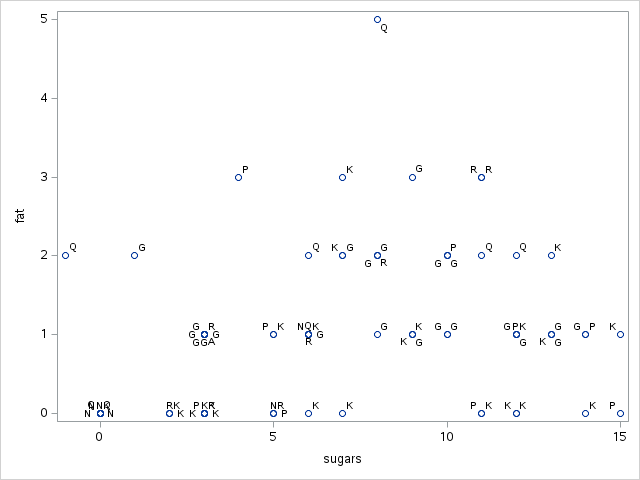

In [64]:
%%SAS sas_sess

/* find relation between fat and sugar within different bands */
PROC sgscatter  DATA = WORK.IMPORT;
   PLOT fat*sugars / datalabel = mfr;

RUN; 



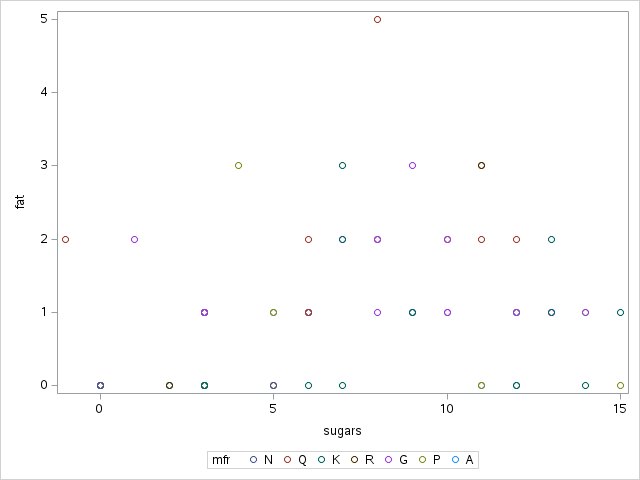

In [65]:
%%SAS sas_sess
proc sgplot data=WORK.IMPORT ;
   scatter x=sugars y=fat / group=mfr;
run;

### Any missing data

In [66]:
%%SAS sas_sess
proc format;
 value $missing_char
              ' '  = 'Missing'
              other = 'Present'
    ;
 value missing_num
    . = 'Missing'
    other = 'Present'
    ;
run;

proc freq data = WORK.IMPORT;
 tables _all_ /missing;
 format _character_ $missing_char. _numeric_ missing_num.;
run;  

name,Frequency,Percent,CumulativeFrequency,CumulativePercent
Present,77,100.00,77,100.00
mfr,Frequency,Percent,CumulativeFrequency,CumulativePercent
Present,77,100.00,77,100.00
type,Frequency,Percent,CumulativeFrequency,CumulativePercent
Present,77,100.00,77,100.00
calories,Frequency,Percent,CumulativeFrequency,CumulativePercent
Present,77,100.00,77,100.00
protein,Frequency,Percent,CumulativeFrequency,CumulativePercent
Present,77,100.00,77,100.00
fat,Frequency,Percent,CumulativeFrequency,CumulativePercent



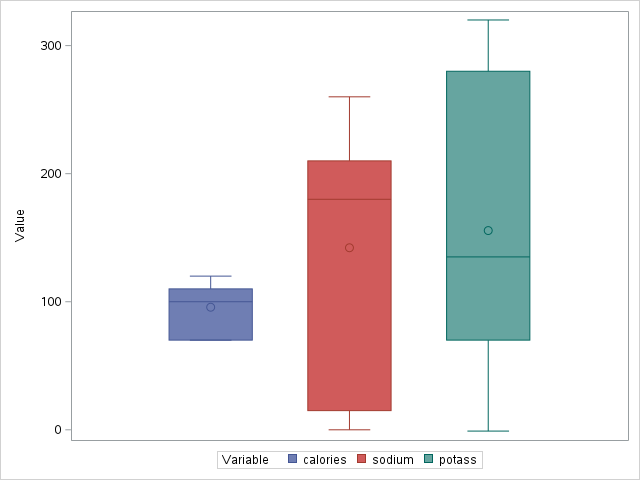

In [67]:
%%SAS sas_sess

proc sort data=WORK.IMPORT  out=raw_t (keep= calories sodium potass mfr);
    by mfr;
run;

proc transpose data=raw_t out=raw_t2;
    by mfr;
run;

data raw_t2 ;
    set raw_t2 ;
    label _name_ = "Variable";
    label col1 = "Value";
run;

proc sgplot data=raw_t2;
    vbox col1 / group=_name_ ;
run;



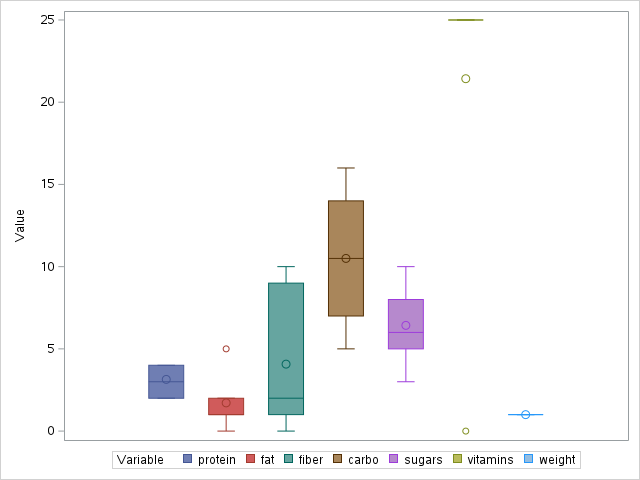

In [68]:
%%SAS sas_sess

proc sort data=WORK.IMPORT  out=raw_t (keep= protein fat fiber carbo sugars vitamins weight mfr);
    by mfr;
run;

proc transpose data=raw_t out=raw_t2;
    by mfr;
run;

data raw_t2 ;
    set raw_t2 ;
    label _name_ = "Variable";
    label col1 = "Value";
    drop shelf;
run;

proc sgplot data=raw_t2;
    vbox col1 / group=_name_ ;
run;



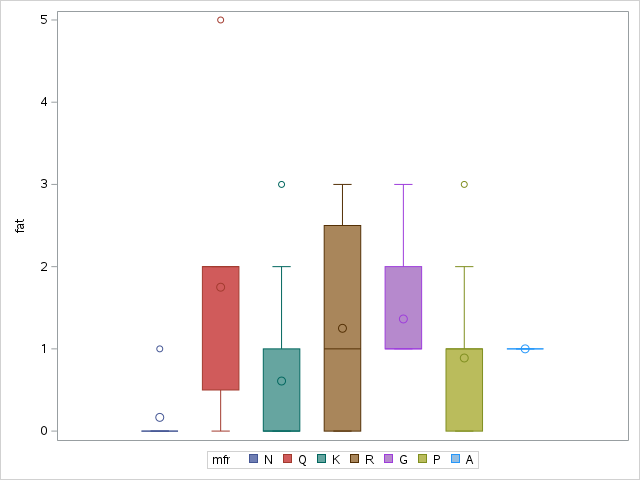
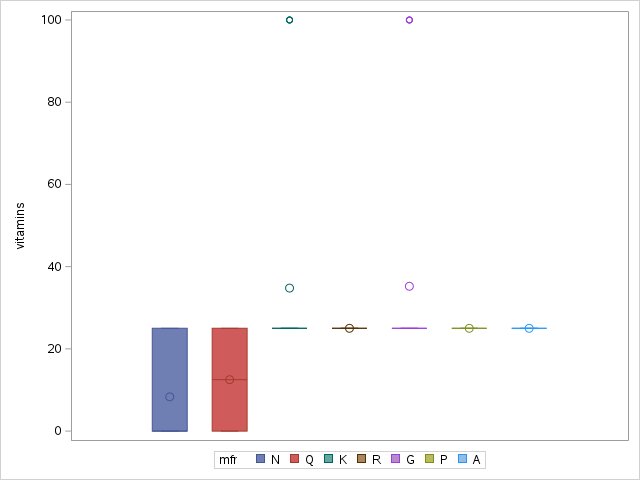
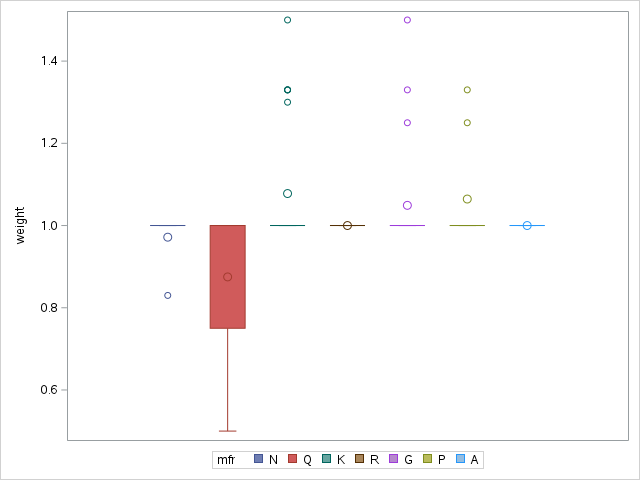

In [69]:
%%SAS sas_sess

proc sgplot data=WORK.IMPORT;
    vbox fat / group=mfr;
run;

proc sgplot data=WORK.IMPORT;
    vbox vitamins / group=mfr;
run;

proc sgplot data=WORK.IMPORT;
    vbox weight / group=mfr;
run;

#### There has large gaps in fat, vitamins and weight from among different bands

In [70]:
%%SAS sas_sess
/* from https://gist.github.com/statgeek/566dda98173a5a28a6e4147317547959 
       https://learn.sas.com/pluginfile.php/7660/mod_resource/content/2/apsoln.htm 
    */
/* Use the pearson data set to print only the correlations whose absolute values are 0.70 and above, 
    or note them with an asterisk in the full correlation table.
    */
    
    
%let big=0.7;
%let interval = protein fat sodium fiber carbo sugars potass vitamins;

proc corr data=WORK.IMPORT 
          nosimple 
          best=5
          out=pearson;  /* output pearson correlations result */
   var &interval;
   title "Correlations of Predictors";
run;

proc format;
    value CorrSignif -0.0-<0.2 = "red"
        0.2-<0.4, -0.4-<-0.2 = "orange"
        0.4-<0.6, -0.6-<-0.4 = "yellow"
        0.6-<0.8, -0.8-<-0.6 = "lightgreen"
        0.8-<1.0, -1.0-<-0.8= "forestgreen"
        1, -1 = "White";
    picture correlations &big -< 1 = '009.99' (prefix="*")
                         -1 <- -&big = '009.99' (prefix="*")
                         -&big <-< &big = '009.99';
run;



proc print data=pearson style(column)={backgroundcolor= CorrSignif.} noobs;
    var _NAME_ &interval;
    where _type_="CORR";
    format &interval correlations.;
    ;
run;


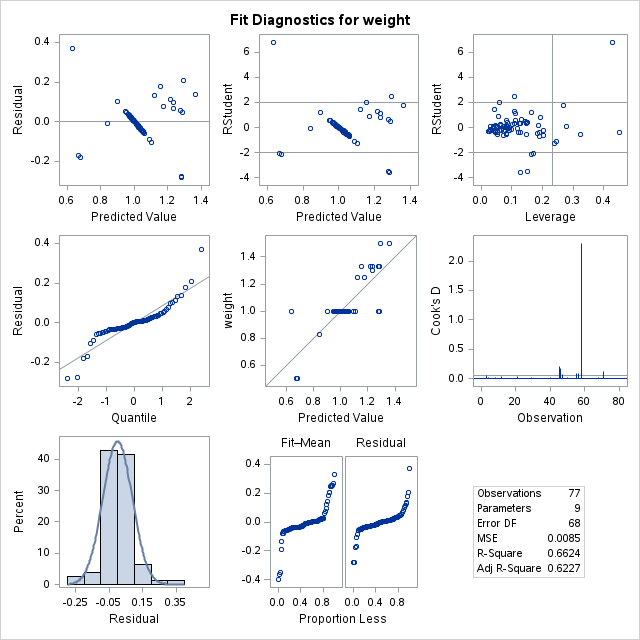
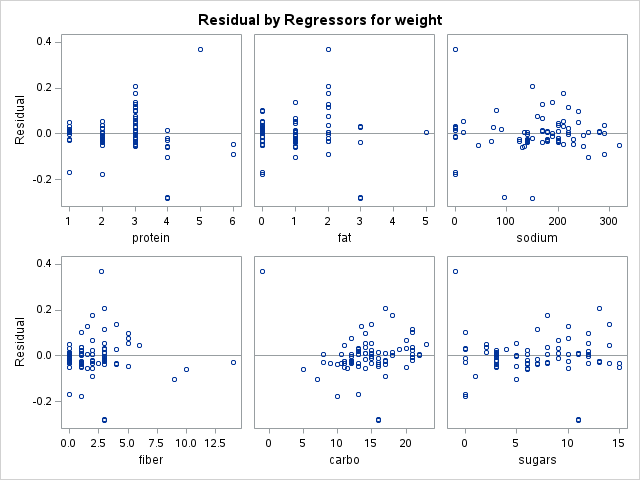
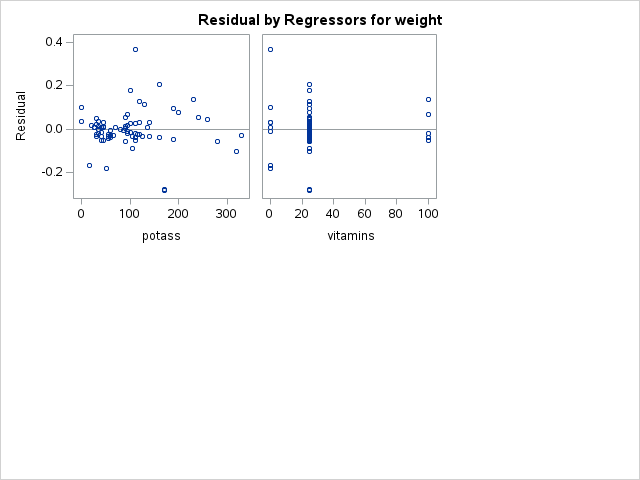

In [71]:
%%SAS sas_sess

/* check Multicollinearity using VIF */ 
/* VIF between 1 and 5: Moderate multicollinearity (not a major concern).
    VIF above 5: High multicollinearity (may lead to unreliable coefficient estimates). */
        
PROC REG DATA=WORK.IMPORT;
   MODEL weight = protein fat sodium fiber carbo sugars potass vitamins / VIF ;
RUN;

####  fiber and potass are highly correlated to each other variables

### Standardize Continuous Variables

#### If do not standardise the data then the variables measured in higher unit will dominate the computed dissimilarity and variables that are measured in small unit will contribute very little.

In [72]:
%%SAS sas_sess

%let interval=protein fat sodium carbo sugars vitamins; /* exclude fiber and potass */

proc stdize data=WORK.IMPORT out=outdata method=std;
    var &interval;
run;


### Principal Components Analysis (PCA)


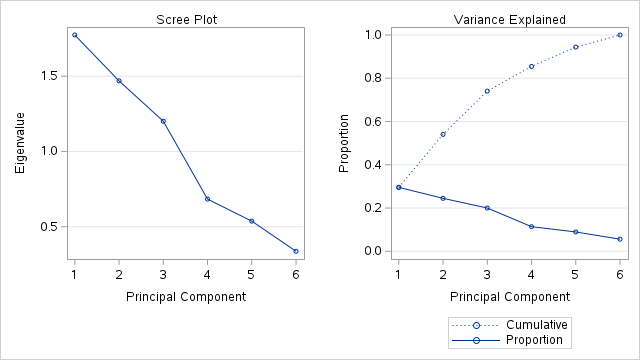

In [73]:
%%SAS sas_sess

/* find principal components – linear combinations of the predictor variables 
– that explain a large portion of the variation in a dataset*/


proc princomp data=outdata out=out_data outstat=stats;  /* Default Method : Based on Correlation Matrix. */
    var &interval;
run;

#### The table in the output titled Eigenvalues of the Correlation Matrix allow us to see exactly what percentage of total variation is explained by each principal component:

    From the table in the output titled Eigenvalues of the Correlation Matrix that the first 5 principal components account for 94.40% of the total variation in the dataset.

#### Eigenvector shows the correlation between component and variable. It explains which variable is highly correlated to a component. Choosing components with eigenvalue > 1 or cumulative proportion of variance more than 80%.

    from https://www.listendata.com/2015/04/principal-component-analysis-with-sas.html
    
    Why Eigenvalues > 1

&nbsp; Each observed variable contributes one unit of variance to the total variance in the data set. Any component that displays an eigenvalue greater than 1.0 is accounting for a greater amount of variance than was contributed by one variable. Such a component is therefore accounting for a meaningful amount of variance and is worthy of being retained. On the other hand, a component with an eigenvalue less than 1.0 is accounting for less variance than had been contributed by one variable.

#### If you run a principal component analysis on a set of 5 variables and observe that the first component explains 85% of the variance. It means the variables are highly correlated to each other. In other words, variables are faced with multicollinearity.

### Biplot to Visualize Results


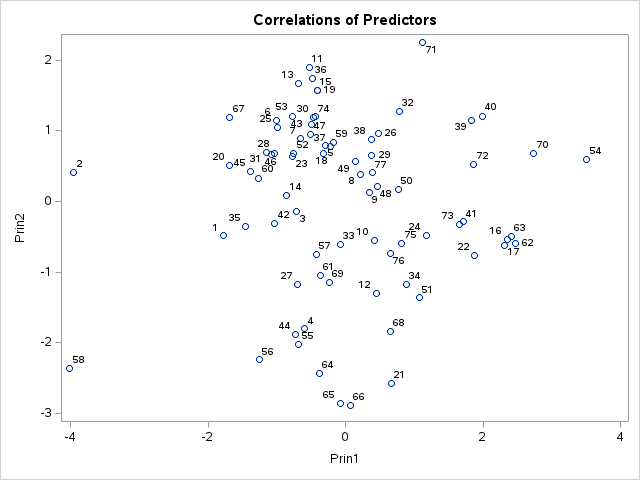

In [74]:
%%SAS sas_sess
/* displays every observation in a dataset on a plane that is formed by the first two principal components. */

/*create dataset with column called obs to represent row numbers of original data*/
data biplot_data;
   set out_data;
   obs=_n_;
run;

/*create biplot using values from first two principal components*/
proc sgplot data=biplot_data;
    scatter x=Prin1 y=Prin2 / datalabel=obs;
run;

#### Observations that are next to each other on the plot have similar values across the 6 variables. For example, on the far right side of the plot we can see that observations #44  and #72 are extremely close to each other.

### Principal Factor Analysis with Parallel Analysis

#### Parallel analysis compares each of eigenvalues of the input data correlation matrix to an empirical distribution of eigenvalues. Each eigenvalue from the input correlation matrix that exceeds a critical value (based on a one-sided -level) in the corresponding empirical distribution suggests a factor to be retained.

#### the scree plot for a parallel analysis contains two lines. The first line is a traditional scree plot and shows the eigenvalues of the sample correlation matrix, sorted in descending order. The second line is constructed from the critical values that are obtained from the parallel analysis. The suggested number of factors to retain is indicated by the intersection of these two lines.

https://documentation.sas.com/doc/en/pgmsascdc/9.4_3.4/statug/statug_factor_examples09.htm


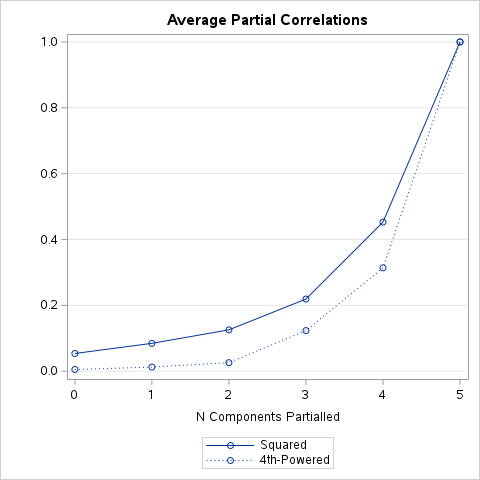
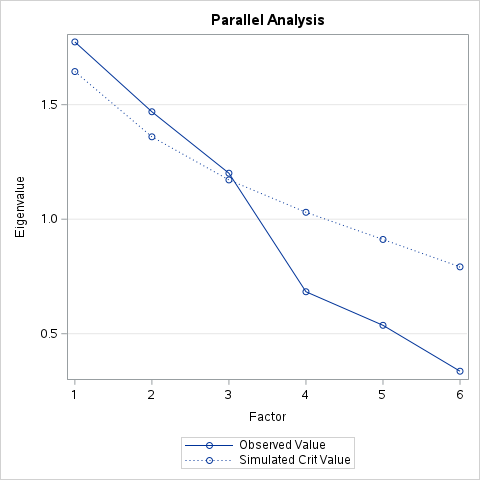
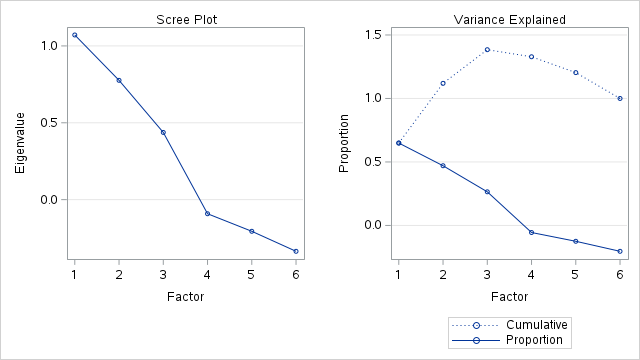
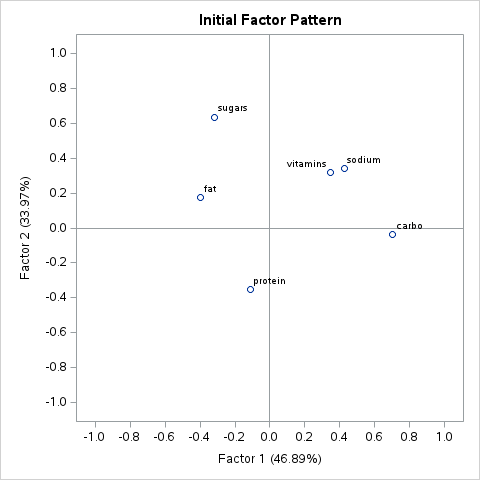
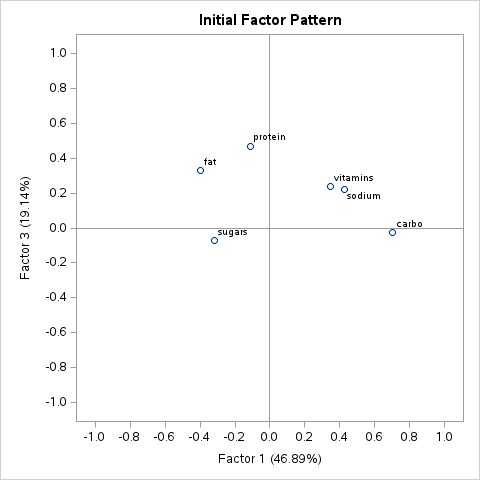
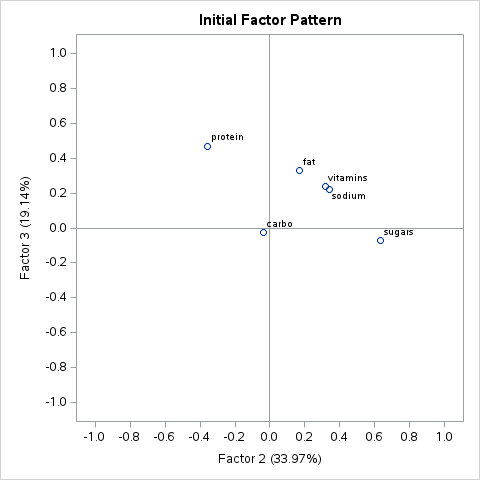
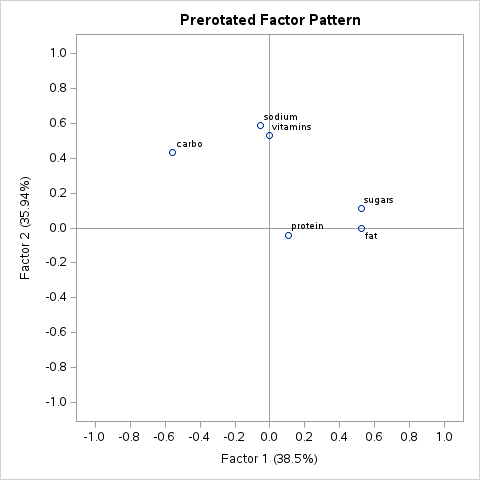
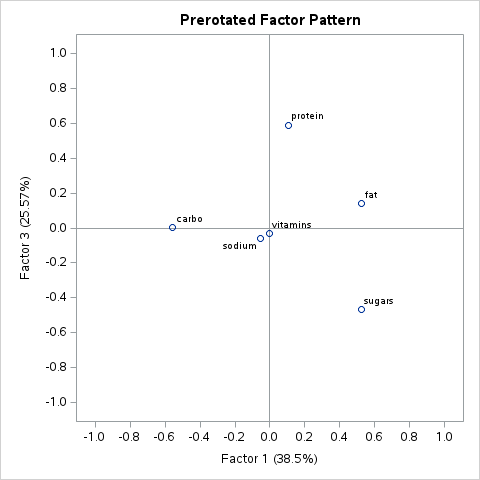
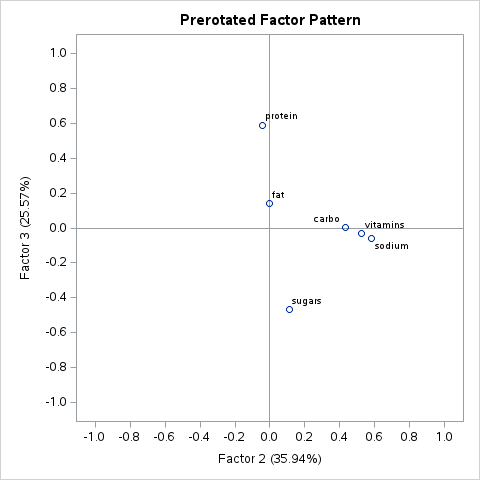
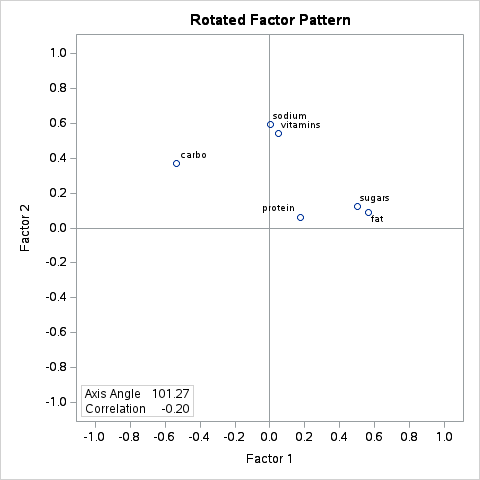
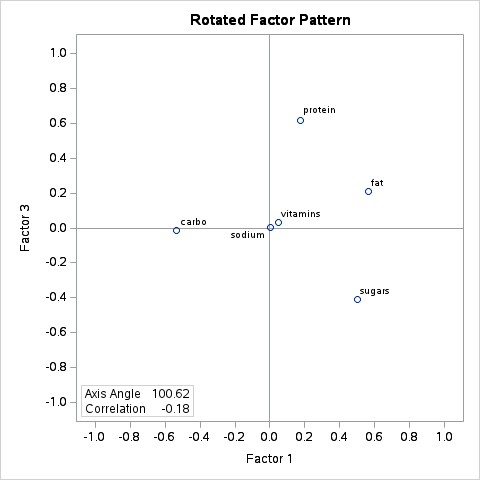
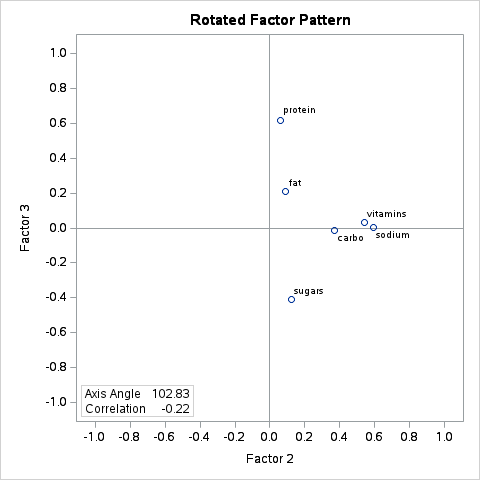

In [75]:
%%SAS sas_sess

proc factor data=outdata corr

   nfactors= parallel(alpha=0.01 nsims=10000 seed=20170229) map  /* Parallel Analysis */
   priors=smc msa residual
   rotate=promax reorder
   outstat=fact_all
   plots=(scree initloadings preloadings loadings parallel map);
    var &interval;
run;

### If the data are appropriate for the common factor model, the partial correlations (controlling all other variables) should be small compared to the original correlations.

Before conducting a principal components analysis, you want to check the correlations between the variables.  If any of the correlations are too high (say above .9), you may need to remove one of the variables from the analysis, as the two variables seem to be measuring the same thing.  Another alternative would be to combine the variables in some way (perhaps by taking the average).  If the correlations are too low, say below .1, then one or more of the variables might load only onto one factor (in other words, make its own factor).  This is not helpful, as the whole point of the analysis is to reduce the number of items (variables). 
    https://stats.oarc.ucla.edu/sas/output/factor-analysis/

Kaiser’s MSA is a summary, for each variable and for all variables together, of how much smaller the partial correlations are than the original correlations. Values of 0.8 or 0.9 are considered good, while MSAs below 0.5 are unacceptable. The variables sugars, fiber and fat have very poor MSAs. 

Only the protein variable has little better MSA. The overall MSA of 0.50 is sufficiently poor that additional variables should be included in the analysis to better define the common factors. 
A commonly used rule is that there should be at least three variables per factor.

### K-means clustering with proc fastclus


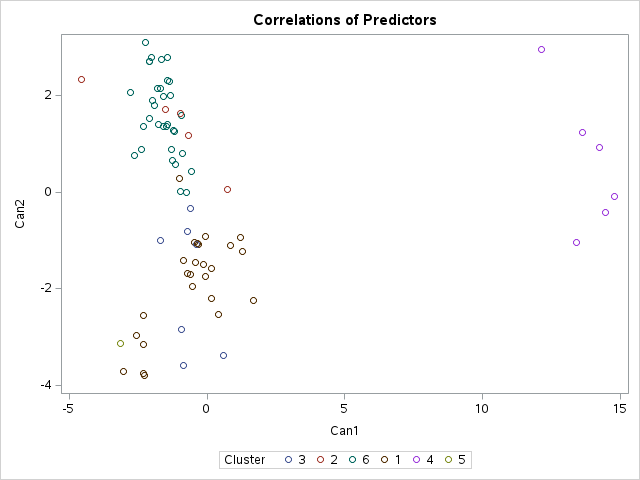

In [76]:
%%SAS sas_sess

/* Note : If you want a complete convergence (i.e. no relative change in cluster seeds), 
    set converge = 0 and a large value for the MAXITER option. */
    
proc fastclus data=outdata /* using standardization data */
    maxclusters=6  /* tells SAS to form the number of clusters using k-means algorithm. */
    maxiter=100 
    converge=0
    mean=mean     /* creates an output data set mean that contains the cluster means and other statistics for each cluster*/
    out=clust;    /*output data set that contains the original variables and two new variables, cluster and distance. */
    var &interval;
run;

/* * Canonical Discriminant Analysis;
 -finds linear combinations of the numeric variables that provide maximal separation between classes or groups.
    */
proc candisc data=clust out=egclustcan;
    var &interval;
    class cluster;
run;

/*Plots the two canonical variables generated from PROC CANDISC, can1 and can2. */

proc sgplot data=egclustcan;
    scatter y=can2 x=can1 / group=cluster;
run; 

Note :
Largest value of CCC greater than 2 or 3 indicate good clusterings.
Largest value of CCC between 0 and 2 indicate possible clusters but should be interpreted cautiously.

    The pseudo-F statistic is intended to capture the 'tightness' of clusters, and is in essence a ratio of the mean sum of squares between groups to the mean sum of squares within group.
    Larger numbers of the pseudo-F usually indicate a better clustering solution. If pseudo-F decreases with k and reaches a maximum value, the value of k at the maximum or immediately prior to the point may be a candidate for the value of k.

#### The clusters are grouped on the basis of maximum distance from seed to observations. Approximate Expected Over-All R-Squared =	0.49631 (<0.7) no a good fit model. The distance between the seed and observation of the first cluster distance is 2.5241, and the 4th cluster is the maximum value.

## Cluster Analysis - K-Means Algorithm


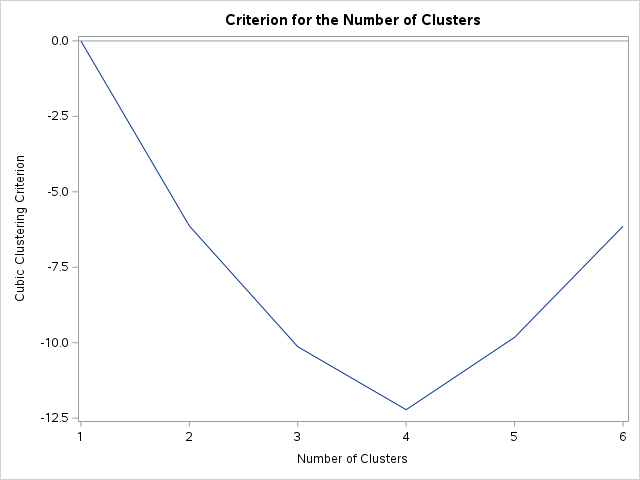
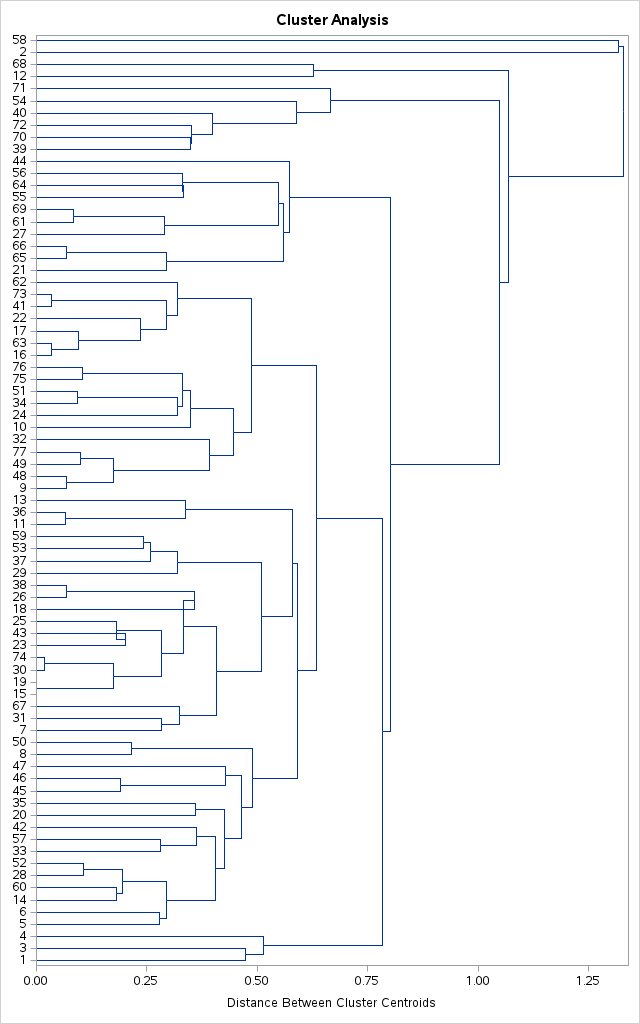

In [77]:
%%SAS sas_sess

/* Perfoming Cluster Analysis - K-Means Algorithm */

proc cluster data = outdata 
    method = centroid /* using the CENTROID method */
    ccc print=6    /* CCC — Cubic Clustering Criterion — It helps to find out the optimum cluster point. */
    outtree=Tree;
    var &interval;
run;

#### The first 5 eigenvalues account for about 94.40% of the total variance, hence, it suggests to go with 5 clusters. However, it can be cross-checked in the ccc plot. From the above CCC plot, it can be seen that elbow has dropped at 4. Hence, the optimum cluster would be 4.


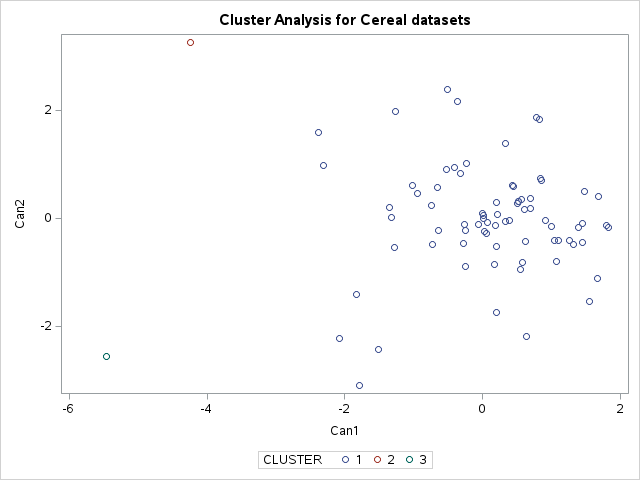

In [78]:
%%SAS sas_sess

/* Retaining 3 clusters */
proc tree data=tree noprint ncl=3 out=out;  /*categorize each observation out of all observations into three clusters */
    copy &interval;
run;

/* To create a Scatterplot */
proc candisc out = can;
    class cluster;
    var &interval;
run;

proc sgplot data = can;
    title "Cluster Analysis for Cereal datasets";
    scatter y = can2 x = can1 / group = cluster;
run;
title;

##### Advantage and Disadvantage of K-means Clustering

    Advantage:

    1) Practically work well even some assumptions are broken.

    2) Simple, easy to implement.

    3) Easy to interpret the clustering results.

    4) Fast and efficient in terms of computational cost.

##### Disadvantage:

    1) Uniform effect often produces clusters with relatively uniform size even if the input data have different cluster size.

    2) Different densities may work poorly with clusters.

    3) Sensitive to outliers.

    4) K value needs to be known before K-means clustering.

https://towardsdatascience.com/k-means-clustering-in-sas-9d19efd4fb1b

### Variable Cluster Analysis

#### Variable Cluster Analysis, (implemented in SAS through PROC VARCLUS), is another variable reduction method that often has distinct advantages over the traditional Factor Analysis (FA) approach. This method borrowed some ideas from the Factor Analysis method and some  from the Hierarchical Clustering method and produces either disjoint or hierarchical clusters.

https://apha.confex.com/apha/responses/134am/7422.ppt


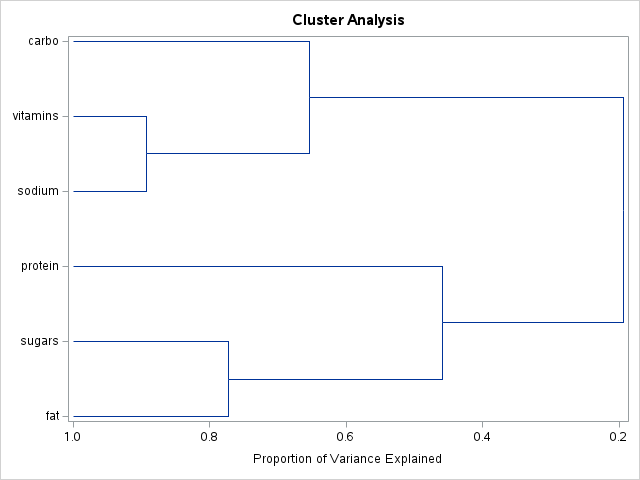

In [79]:
%%SAS sas_sess

proc varclus data=outdata outtree=tree centroid maxclusters=6;
      var &interval;
run;

#### the variables are formed into 4 clusters, 1st cluster contains the variables sodium, vitamins, but split as the variable carbo forms the 4th cluster. 2nd cluster contains , sugars and fat but split as the variable protein forms the 3rd clusters

Other SAS Proc for cluster Analysis: https://data-flair.training/blogs/stat-cluster-analysis/
<img src="SAS-STAT-CLUSTER-ANALYSIS-01.jpg" alt="CLUSTER-ANALYSIS image" />

    Reference:
        - https://www.listendata.com/2014/10/cluster-analysis-using-sas.html
        - https://www.statology.org/principal-components-analysis-in-sas/
        - https://stats.oarc.ucla.edu/sas/output/factor-analysis/
        - https://documentation.sas.com/doc/en/pgmsascdc/9.4_3.4/statug/statug_factor_examples03.htm
        - https://www.sfu.ca/sasdoc/sashtml/stat/chap68/sect3.htm